# NAMED ENTITY MODEL

## IMPORT RAW DATA AND LOAD A MODEL

In [204]:
# Import and load the spacy model
import spacy
import random
import json

## PREPARE TRAINING DATA

In [205]:
from util import prepare_training_data, trim_entity_spans, train_test_split

In [207]:
RAW_DATA = prepare_training_data('dataset/postings_annotated_draft_2.jsonl')
CLEANED_DATA = trim_entity_spans(RAW_DATA)

In [209]:
random.shuffle(CLEANED_DATA)
CLEANED_DATA[3]

['2014 nissan sentra condition: excellent cylinders: 4 cylinders fuel: gas odometer: 101000 paint color: black size: compact title status: clean transmission: automatic 2014 Nissan Sentra with only 100k +, runs and drives great. Power windows and doors, Automatic transmission , Clean interior and exterior. Very economical and gas saver.  Asking for 7000 or best offer. If interested,  call  show contact info ',
 {'entities': [[0, 4, 'YEAR'],
   [5, 11, 'MAKE'],
   [12, 18, 'MODEL'],
   [349, 353, 'ASKINGPRICE']]}]

## DATASET OVERVIEW

In [210]:
import seaborn as sns

In [221]:
dataset_df = pd.read_json('dataset/postings_annotated_draft_2.jsonl', lines=True)

### DATA TOTAL LENGTH

In [284]:
dataset_df['data'].str.len().describe()

count     622.000000
mean      718.278135
std       601.325370
min       163.000000
25%       377.250000
50%       532.500000
75%       853.000000
max      5933.000000
Name: data, dtype: float64

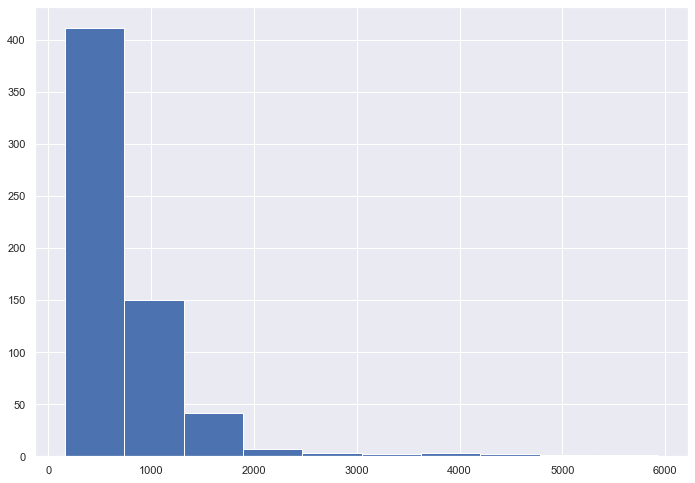

In [285]:
dataset_df['data'].str.len().hist()
plt.show()

### DATA WORDS LENGTH

In [296]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).hist()

In [297]:
dataset_df['data'].str.split().map(lambda x: len(x)).describe()

count     622.000000
mean      113.924437
std        99.966125
min        24.000000
25%        58.000000
50%        84.500000
75%       137.000000
max      1082.000000
Name: data, dtype: float64

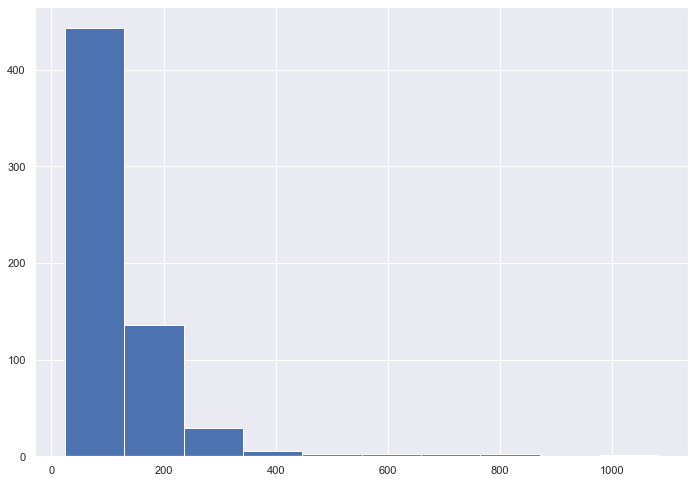

In [298]:
plot_word_number_histogram(dataset_df['data'])

### STOP WORDS

In [288]:
# Code Snippet for Top Stopwords Barchart
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

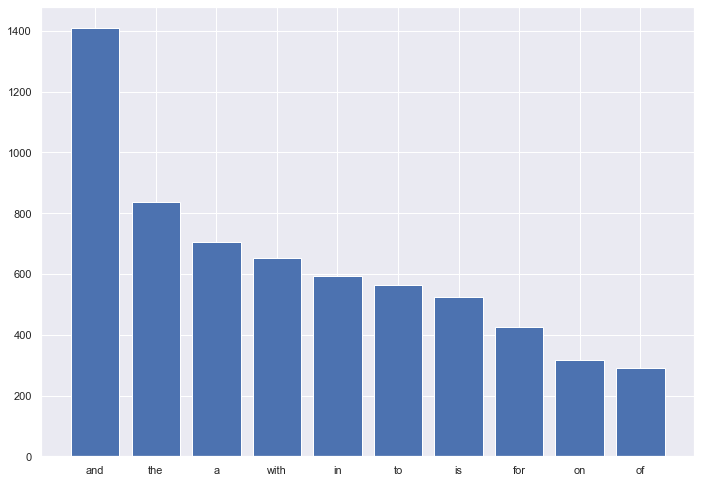

In [289]:
plot_top_stopwords_barchart(dataset_df['data'])

### NON STOPWORDS

In [290]:
# Code Snippet for Top Non-Stopwords Barchart

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x=y,y=x)

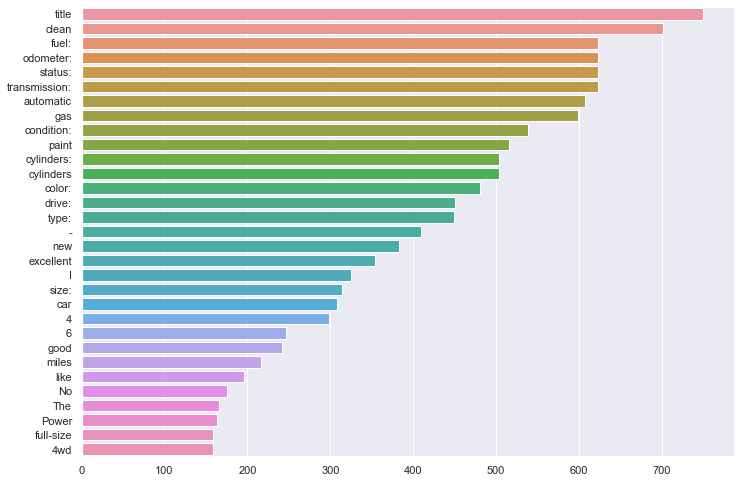

In [291]:
plot_top_non_stopwords_barchart(dataset_df['data'])

### TOP N-GRAM

In [292]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

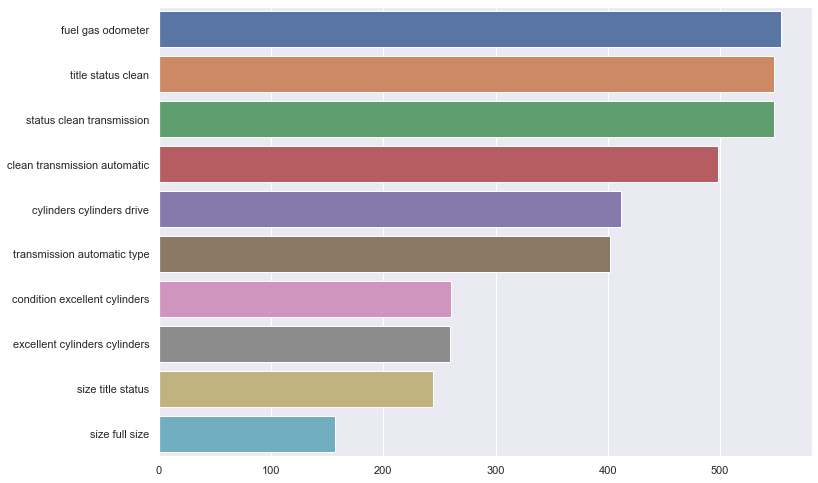

In [293]:
top_tri_grams=get_top_ngram(dataset_df['data'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

### WORD CLOUD

In [275]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=32,
        scale=3,
        random_state=None)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

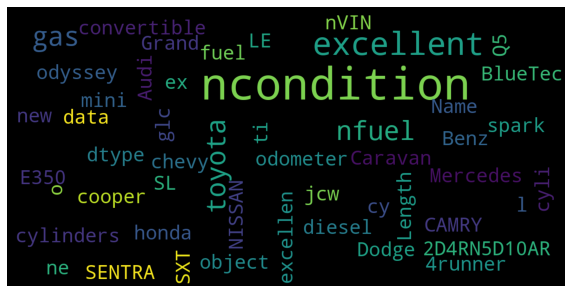

In [276]:
show_wordcloud(dataset_df['data'])

## SETUP TRAINING/TESTING

In [5]:
TRAINING_DATA, TESTING_DATA = train_test_split(CLEANED_DATA, 0.8)

In [14]:
TESTING_DATA[0]

['2017 Porsche 911 Turbo S fuel: gas odometer: 6000 title status: clean transmission: automatic CPO Warranty until April 2023!  Full Body PPF!  Always garaged, like NEW, immaculate beast!  Only 6K miles!    ',
 {'entities': [[0, 4, 'YEAR'],
   [5, 12, 'MAKE'],
   [13, 16, 'MODEL'],
   [17, 24, 'TRIM']]}]

#### TRAINING, TESTING SHAPE

In [6]:
len(TRAINING_DATA), len(TESTING_DATA)

(497, 124)

## SETUP BLANK MODEL AND TRAINING

In [10]:
import spacy
import random
import json
from tqdm import tqdm
from spacy.training.example import Example
nlp = spacy.blank("en")
ner = nlp.create_pipe("ner")
nlp.add_pipe('ner')
# Start the training
nlp.begin_training()
# Loop for 40 iterations
for itn in tqdm(range(30)):
    # Shuffle the training data
    losses = {}
    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=2):
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            # Update the model
            nlp.update([example], losses=losses, drop=0.3)
    print(losses)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "2017 glc 300 condition: like new cylinders: 4 cyli..." with entities "[[0, 4, 'YEAR'], [452, 466, 'PHONE'], [167, 171, '...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "2015 Audi Q5 condition: excellent fuel: gas odomet..." with entities "[[0, 4, 'YEAR'], [5, 9, 'MAKE'], [10, 12, 'MODEL']...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning:

{'ner': 4079.294134336907}


  7%|▋         | 2/30 [00:50<12:04, 25.86s/it]

{'ner': 2470.9123410156653}


 10%|█         | 3/30 [01:13<10:54, 24.23s/it]

{'ner': 2240.9867086329464}


 13%|█▎        | 4/30 [01:39<10:48, 24.95s/it]

{'ner': 1807.4164162576465}


 17%|█▋        | 5/30 [02:04<10:22, 24.92s/it]

{'ner': 1583.756032508156}


 20%|██        | 6/30 [02:26<09:32, 23.87s/it]

{'ner': 1416.5199390248083}


 23%|██▎       | 7/30 [02:47<08:52, 23.17s/it]

{'ner': 1327.7498341902553}


 27%|██▋       | 8/30 [03:09<08:20, 22.77s/it]

{'ner': 1140.7615303743423}


 30%|███       | 9/30 [03:31<07:52, 22.49s/it]

{'ner': 1100.3737585633999}


 33%|███▎      | 10/30 [03:53<07:24, 22.20s/it]

{'ner': 981.8347130314344}


 37%|███▋      | 11/30 [04:14<06:56, 21.94s/it]

{'ner': 1025.543598634185}


 40%|████      | 12/30 [04:35<06:32, 21.81s/it]

{'ner': 916.8910854370708}


 43%|████▎     | 13/30 [04:57<06:09, 21.74s/it]

{'ner': 868.2551503342148}


 47%|████▋     | 14/30 [05:19<05:47, 21.69s/it]

{'ner': 867.5102866284128}


 50%|█████     | 15/30 [05:40<05:25, 21.72s/it]

{'ner': 837.698850250793}


 53%|█████▎    | 16/30 [06:02<05:03, 21.66s/it]

{'ner': 848.455811906985}


 57%|█████▋    | 17/30 [06:24<04:42, 21.71s/it]

{'ner': 750.723922874041}


 60%|██████    | 18/30 [06:46<04:20, 21.74s/it]

{'ner': 718.3155765789263}


 63%|██████▎   | 19/30 [07:07<03:59, 21.81s/it]

{'ner': 721.6145934094567}


 67%|██████▋   | 20/30 [07:29<03:37, 21.71s/it]

{'ner': 658.1915578327115}


 70%|███████   | 21/30 [07:50<03:14, 21.63s/it]

{'ner': 643.8538370028107}


 73%|███████▎  | 22/30 [08:12<02:53, 21.64s/it]

{'ner': 633.9355696902469}


 77%|███████▋  | 23/30 [08:33<02:30, 21.54s/it]

{'ner': 569.1518337179139}


 80%|████████  | 24/30 [08:56<02:10, 21.72s/it]

{'ner': 584.7034585538081}


 83%|████████▎ | 25/30 [09:17<01:48, 21.69s/it]

{'ner': 612.8853199997453}


 87%|████████▋ | 26/30 [09:39<01:26, 21.70s/it]

{'ner': 597.4262081919803}


 90%|█████████ | 27/30 [10:01<01:05, 21.72s/it]

{'ner': 589.1559114167914}


 93%|█████████▎| 28/30 [10:22<00:43, 21.60s/it]

{'ner': 565.0971913907778}


 97%|█████████▋| 29/30 [10:43<00:21, 21.48s/it]

{'ner': 505.35787375975764}


100%|██████████| 30/30 [11:05<00:00, 22.17s/it]

{'ner': 465.54068676520535}


## EVALUATION

In [11]:
from train import get_score

In [12]:
get_score(nlp, TESTING_DATA)

/usr/local/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "2011 honda accord exl condition: good cylinders: 4..." with entities "[[0, 4, 'YEAR'], [5, 10, 'MAKE'], [11, 17, 'MODEL'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "2016 Toyota Tacoma TRD condition: like new cylinde..." with entities "[[0, 4, 'YEAR'], [5, 11, 'MAKE'], [12, 18, 'MODEL'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'ents_p': 0.7229965156794426,
 'ents_r': 0.6566455696202531,
 'ents_f': 0.6882255389718075,
 'ents_per_type': {'YEAR': {'p': 0.7558139534883721,
   'r': 0.8125,
   'f': 0.783132530120482},
  'MAKE': {'p': 0.7658227848101266,
   'r': 0.7960526315789473,
   'f': 0.7806451612903226},
  'MODEL': {'p': 0.6573426573426573,
   'r': 0.6266666666666667,
   'f': 0.6416382252559727},
  'TRIM': {'p': 0.660377358490566,
   'r': 0.3977272727272727,
   'f': 0.4964539007092199},
  'ASKINGPRICE': {'p': 0.5909090909090909,
   'r': 0.38235294117647056,
   'f': 0.46428571428571425},
  'VIN': {'p': 0.8636363636363636,
   'r': 0.7037037037037037,
   'f': 0.7755102040816326},
  'PHONE': {'p': 0.75, 'r': 0.14285714285714285, 'f': 0.24}}}

In [13]:
nlp.to_disk('models/mca-ner-draft_0.model')

# WORD SIMILARITY

In [129]:
word_example ='2017 Porsche 911 Turbo S fuel: gas odometer: 6000 title status: clean transmission: \
automatic CPO Warranty until April 2023!  Full Body PPF!  Always garaged, like NEW, immaculate beast!  Only 6K miles!    '

In [130]:
word_example = nlp(word_example)

In [131]:
for ent in word_example.ents:
    print(ent.label_ + ":", ent.text)

YEAR: 2017
MAKE: Porsche
MODEL: 911
TRIM: Turbo S


## LOAD TRAGET

In [19]:
import pandas as pd

In [117]:
target_dict = pd.read_csv('vehicle_combo.csv')
target_dict

,make,model,trim
0,ACURA,ILX,4D SEDAN
1,ACURA,ILX,4D ACURAWATCH PLUS SEDAN
2,ACURA,ILX,4D PREMIUM SEDAN
3,ACURA,ILX,4D A-SPEC PREMIUM SEDAN
4,ACURA,ILX,4D PKG SEDAN TECH
...,...,...,...
14806,VOLVO,XC60,4D MOMENTUM SUV T6
14807,VOLVO,XC60,4D R-DESIGN SUV T6
14808,VOLVO,HYBRID XC60,4D INSCRIPTION SUV T8
14809,VOLVO,HYBRID XC60,4D MOMENTUM SUV T8


In [118]:
target_dict[target_dict['make'] == 'PORSCHE']

,make,model,trim
2116,PORSCHE,2WD 911,2D CARRERA CONVERTIBLE
2117,PORSCHE,2WD 911,2D BLK CARRERA CONVERTIBLE ED
2118,PORSCHE,2WD 911,2D CARRERA CONVERTIBLE GTS
2119,PORSCHE,2WD 911,2D CARRERA CONVERTIBLE S
2120,PORSCHE,2WD 911,2D CARRERA COUPE
...,...,...,...
14744,PORSCHE,AWD PANAMERA V6,3.0L 4 4D SPORT TURISMO
14745,PORSCHE,AWD HYBRID PANAMERA V6,2.9L 4 4D E-HYBRID HATCHBACK
14746,PORSCHE,AWD PANAMERA V8,4D SPORT TURBO TURISMO
14747,PORSCHE,AWD HYBRID PANAMERA V8,4D E-HYB EXEC HATCHBACK S TURBO


In [172]:
target_dict['target'] = target_dict['make'] + ' | ' + target_dict['model'] + ' | ' + target_dict['trim']
target_dict

,make,model,trim,target
0,ACURA,ILX,4D SEDAN,ACURA | ILX | 4D SEDAN
1,ACURA,ILX,4D ACURAWATCH PLUS SEDAN,ACURA | ILX | 4D ACURAWATCH PLUS SEDAN
2,ACURA,ILX,4D PREMIUM SEDAN,ACURA | ILX | 4D PREMIUM SEDAN
3,ACURA,ILX,4D A-SPEC PREMIUM SEDAN,ACURA | ILX | 4D A-SPEC PREMIUM SEDAN
4,ACURA,ILX,4D PKG SEDAN TECH,ACURA | ILX | 4D PKG SEDAN TECH
...,...,...,...,...
14806,VOLVO,XC60,4D MOMENTUM SUV T6,VOLVO | XC60 | 4D MOMENTUM SUV T6
14807,VOLVO,XC60,4D R-DESIGN SUV T6,VOLVO | XC60 | 4D R-DESIGN SUV T6
14808,VOLVO,HYBRID XC60,4D INSCRIPTION SUV T8,VOLVO | HYBRID XC60 | 4D INSCRIPTION SUV T8
14809,VOLVO,HYBRID XC60,4D MOMENTUM SUV T8,VOLVO | HYBRID XC60 | 4D MOMENTUM SUV T8


## SIMILARITY MAPPING
### NORMAL LEAD

In [145]:
nlp_similarity = spacy.load('en_core_web_lg')
def get_similarity(search_doc, main_doc):
    search_doc = nlp_similarity(search_doc)
    main_doc = nlp_similarity(main_doc)
    return main_doc.similarity(search_doc)

In [180]:
search_docs = list(target_dict['target'])

In [190]:
all_sim = []
name_list = []
for search_doc in tqdm(search_docs):
    similarity_score = get_similarity(search_doc, 'Porsche | 911 | Turbo S')
    all_sim.append(similarity_score)
    name_list.append(search_doc)
#     print(search_doc, similarity_score)

100%|██████████| 14811/14811 [02:06<00:00, 117.01it/s]


In [191]:
all_sim = np.array(all_sim)
idx = (-all_sim).argsort()[:10]

In [192]:
np.array(name_list)[idx]

array(['PORSCHE | 911 TURBO | COUPE', 'PORSCHE | 911 TURBO | COUPE TURBO',
       'PORSCHE | 2 911 CARRERA | COUPE',
       'PORSCHE | 911 AWD | 2D CONVERTIBLE S TURBO',
       'PORSCHE | 911 AWD | 2D COUPE S TURBO',
       'PORSCHE | 4 911 CARRERA | CABRIOLET',
       'PORSCHE | 2 911 CARRERA | CABRIOLET', 'PORSCHE | 911 GT2 | COUPE',
       'PORSCHE | TAYCAN | 4D S SEDAN TURBO',
       'PORSCHE | 2WD 911 | 2D CARRERA COUPE S'], dtype='<U75')

In [193]:
all_sim[idx]

array([0.95007781, 0.92322532, 0.90973952, 0.90691871, 0.9046976 ,
       0.89790356, 0.89648135, 0.89636538, 0.89299508, 0.88962282])

### NO_MMR LEAD

In [132]:
no_mmr = '2005 ford f450 super duty condition: \
fair cylinders: 8 cylinders drive: 4wd fuel: diesel odometer: 117391 paint color: \
                    white size: full-size title status: clean transmission: automatic type: truck Ford F 450 flatbed with hydraulic dump truck capability'

In [133]:
no_mmr = nlp(no_mmr)

In [135]:
for ent in no_mmr.ents:
    print(ent.label_ + ":", ent.text)

YEAR: 2005
MAKE: ford
MODEL: f450
TRIM: super duty


In [186]:
all_sim_no_mmr = []
name_list_no_mmr = []
for search_doc in tqdm(search_docs):
    similarity_score = get_similarity(search_doc, 'ford | f450 | super duty')
    all_sim_no_mmr.append(similarity_score)
    name_list_no_mmr.append(search_doc)

100%|██████████| 14811/14811 [02:05<00:00, 118.33it/s]


In [187]:
all_sim_no_mmr = np.array(all_sim_no_mmr)
idx = (-all_sim_no_mmr).argsort()[:10]

In [188]:
np.array(name_list_no_mmr)[idx]

array(['FORD | 4WD F450 TDSL V8 | 6.7L CAB CREW LIMITED',
       'FORD | 4WD F450 TDSL V8 | 6.4L CAB CREW LARIAT',
       'FORD | 4WD F450 TDSL V8 | 6.7L CAB CREW LARIAT',
       'FORD | 4WD F450 TDSL V8 | 6.7L CAB CREW XL',
       'FORD | 4WD F450 TDSL V8 | 6.4L CAB CREW XL',
       'FORD | 4WD F450 TDSL V8 | 6.4L CAB CREW DAVIDSON HARLEY',
       'FORD | 2WD F450 TDSL V8 | 6.4L CAB CREW XL',
       'FORD | 2WD F450 TDSL V8 | 6.4L CAB CREW LARIAT',
       'FORD | FREESTAR | 3.9L CARGO',
       'FORD | 4WD F450 TDSL V8 | 6.7L CAB CREW PLATINUM'], dtype='<U75')

In [189]:
all_sim_no_mmr[idx]

array([0.84682153, 0.84244715, 0.84244715, 0.8414782 , 0.8414782 ,
       0.83514986, 0.83433393, 0.83385211, 0.83370627, 0.83244071])